In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import numbers
import time

2.0.0-alpha0


In [2]:
def make_circles(grid = 10, n_data = 10):    
    max_distance = int(grid/2)-1
    radii = np.random.randint(max_distance/4,max_distance,size = (n_data, 2))
    distances = np.array([np.random.randint(max_distance) for i in range(n_data)])
    circles = np.zeros((n_data, grid, grid))
    for j in range(distances.size):
        for k in range(2):
            r = radii[j][k]
            for l in range(grid):
                for m in range(grid):
                    if k == 0:
                        x = l - max_distance + distances[j]/2
                    else:
                        x = l - max_distance - distances[j]/2
                    y = m - max_distance
                    position = math.sqrt(x**2 + y**2)
                    if position <= r:
                        p = np.exp((-1./2.)*(3*position/r)**2.)
                        circles[j][l][m] += p
    circles = circles.reshape(n_data,grid**2)
    distances = distances.reshape(n_data,1)
    return circles, radii, distances
    

Make data:

In [33]:
grid = 100
n_data = 500
toc = time.clock()
circleData, radiiLabels, distanceLabels = make_circles(grid, n_data)
tic = time.clock()
print(tic-toc)

19.181212


Print a plot of data to see what it looks like!

radius = 
[33 20]
distance between centers = 
[25]


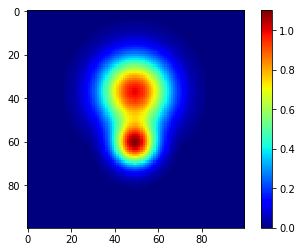

In [34]:
display = circleData[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius = ")
print(radiiLabels[60])
print("distance between centers = ")
print(distanceLabels[60])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

In [16]:
distanceData = circleData#.reshape(n_data, grid, grid, 1)

split = int(0.8*len(circleData))
train_data = distanceData[:split]
train_labels = distanceLabels[:split]
print (train_data.shape)
test_data = distanceData[split:]
print(test_data.shape)
test_labels = distanceLabels[split:]

(400, 100, 100, 1)
(100, 100, 100, 1)


Build DNN:

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error', 'mean_absolute_error'])
  return model

Initialize model:

In [ ]:
model_circ = build_model()

Test model's prediction $before$ training:

In [19]:
example_batch = train_data[:10]
example_labels = train_labels[:10]
example_result = model_circ.predict(example_batch)
results = model_circ.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 7ms/sample - loss: 931.5746 - mean_squared_error: 931.5746 - mean_absolute_error: 25.7797


array([[0.00708037],
       [0.02884658],
       [0.02262416],
       [0.03240471],
       [0.02838047],
       [0.03342142],
       [0.01190095],
       [0.04110019],
       [0.01366154],
       [0.0105378 ]], dtype=float32)

Now train! (warning: this is when my computer tends to get loud)

In [21]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')
    
EPOCHS = 100

history = model_circ.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2,
  callbacks=[PrintDot()])

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 2s 6ms/sample - loss: 4.5533 - mean_squared_error: 4.5533 - mean_absolute_error: 1.6698 - val_loss: 3.4899 - val_mean_squared_error: 3.4899 - val_mean_absolute_error: 1.5425
Epoch 2/100
320/320 [==============================] - 2s 5ms/sample - loss: 3.6115 - mean_squared_error: 3.6115 - mean_absolute_error: 1.4603 - val_loss: 3.2708 - val_mean_squared_error: 3.2708 - val_mean_absolute_error: 1.4911
Epoch 3/100
320/320 [==============================] - 2s 5ms/sample - loss: 4.2053 - mean_squared_error: 4.2053 - mean_absolute_error: 1.5976 - val_loss: 4.9287 - val_mean_squared_error: 4.9287 - val_mean_absolute_error: 1.8936
Epoch 4/100
320/320 [==============================] - 2s 5ms/sample - loss: 3.9351 - mean_squared_error: 3.9351 - mean_absolute_error: 1.5496 - val_loss: 2.7000 - val_mean_squared_error: 2.7000 - val_mean_absolute_error: 1.2497
Epoch 5/100
320/320 [==================

Epoch 36/100
320/320 [==============================] - 2s 5ms/sample - loss: 0.9902 - mean_squared_error: 0.9902 - mean_absolute_error: 0.7250 - val_loss: 0.6787 - val_mean_squared_error: 0.6787 - val_mean_absolute_error: 0.6394
Epoch 37/100
320/320 [==============================] - 2s 5ms/sample - loss: 0.9241 - mean_squared_error: 0.9241 - mean_absolute_error: 0.7103 - val_loss: 1.1240 - val_mean_squared_error: 1.1240 - val_mean_absolute_error: 0.8676
Epoch 38/100
320/320 [==============================] - 2s 6ms/sample - loss: 0.9653 - mean_squared_error: 0.9653 - mean_absolute_error: 0.7564 - val_loss: 1.0953 - val_mean_squared_error: 1.0953 - val_mean_absolute_error: 0.8282
Epoch 39/100
320/320 [==============================] - 2s 6ms/sample - loss: 1.1490 - mean_squared_error: 1.1490 - mean_absolute_error: 0.8065 - val_loss: 0.6712 - val_mean_squared_error: 0.6712 - val_mean_absolute_error: 0.6615
Epoch 40/100
320/320 [==============================] - 2s 6ms/sample - loss: 0.

Epoch 72/100
320/320 [==============================] - 2s 5ms/sample - loss: 1.0905 - mean_squared_error: 1.0905 - mean_absolute_error: 0.8114 - val_loss: 0.5040 - val_mean_squared_error: 0.5040 - val_mean_absolute_error: 0.5725
Epoch 73/100
320/320 [==============================] - 2s 5ms/sample - loss: 0.7508 - mean_squared_error: 0.7508 - mean_absolute_error: 0.6415 - val_loss: 0.8601 - val_mean_squared_error: 0.8601 - val_mean_absolute_error: 0.7276
Epoch 74/100
320/320 [==============================] - 2s 5ms/sample - loss: 1.0341 - mean_squared_error: 1.0341 - mean_absolute_error: 0.7343 - val_loss: 0.6475 - val_mean_squared_error: 0.6475 - val_mean_absolute_error: 0.6080
Epoch 75/100
320/320 [==============================] - 2s 5ms/sample - loss: 0.8746 - mean_squared_error: 0.8746 - mean_absolute_error: 0.7152 - val_loss: 0.6793 - val_mean_squared_error: 0.6793 - val_mean_absolute_error: 0.6332
Epoch 76/100
320/320 [==============================] - 2s 5ms/sample - loss: 0.

Now make a plot that shows the pregression of accuracy through each training epoch.

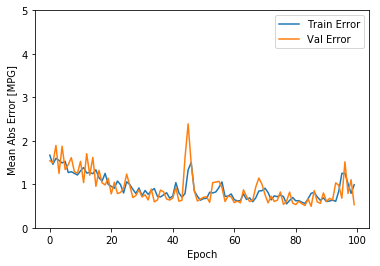

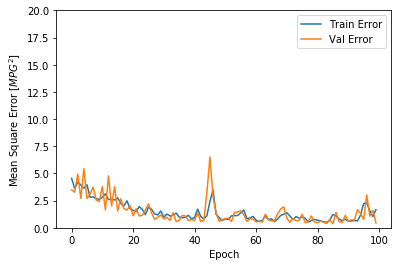

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Now have the model train with "early stopping". the tensorflow "early stopping" function has the training stop according to a monitor. In our case, we are stopping it when the monitor sees an insufficient change in variable loss within the last ten epochs.


.......................................................................

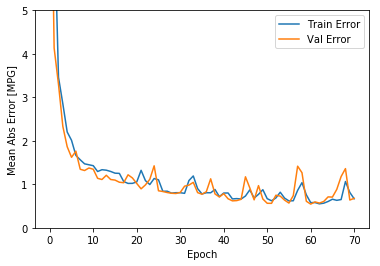

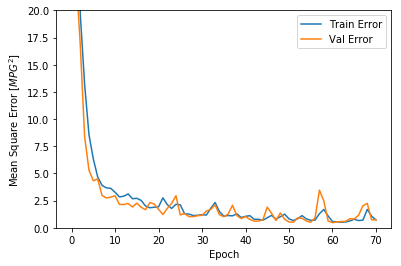

In [24]:
model_circ = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_earlyStop = model_circ.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history_earlyStop)

In [25]:
results = model_circ.evaluate(test_data, test_labels)

100/100 [==============================] - 0s 2ms/sample - loss: 1.0424 - mean_squared_error: 1.0424 - mean_absolute_error: 0.7941


Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

Multilayer perceptron: initial MSE ~ 656.7611; final MSE ~ 0.8408.

CNN: initial MSE ~ 1170.2961; final MSE ~ 1.6238.

CNN w/ MaxPooling layer: initial MSE ~ 1167.0415; final ~ MSE 0.4101.

CNN w/ AveragePooling layer: initial MSE ~ 804.62; final ~ 0.78.

In [ ]:
test_predictions = model_circ.predict(test_data)
results = model_circ.evaluate(test_data, test_labels)
plt.scatter(test_labels.flatten(), test_predictions.flatten())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Now let's use the same network to predict radii!

To use CNN, uncomment "circleData = circleData.reshape(n_data, grid, grid, 1)"

In [35]:
#circleData = circleData.reshape(n_data, grid, grid, 1)
split = int(0.8*len(circleData))
train_data_rad = circleData[:split]
train_labels_rad = radiiLabels[:split]
test_data_rad = circleData[split:]
test_labels_rad = radiiLabels[split:]

To implement basic CNN, uncomment "layers.Conv2D(32, (3, 3), activation='relu')," and "layers.Flatten()"

To implement MaxPooling CNN, uncomment "layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),"


In [36]:
def build_model_rad():
  model = keras.Sequential([
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.AveragePooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'), 
    #layers.MaxPooling2D((2, 2)),
    #layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error', 'accuracy'])
  return model

In [37]:
model_rad = build_model_rad()
example_batch = train_data_rad[:10]
example_labels = train_labels_rad[:10]
example_result = model_rad.predict(example_batch)
results = model_rad.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 5ms/sample - loss: 898.2560 - mean_absolute_error: 27.7654 - mean_squared_error: 898.2560 - accuracy: 0.6000


array([[ 0.17449546,  0.07974399],
       [ 0.12608515,  0.11819054],
       [ 0.05521492, -0.02854218],
       [ 0.16112706,  0.06114392],
       [ 0.03449192,  0.08559342],
       [ 0.1072965 ,  0.1523971 ],
       [-0.09341439,  0.03275807],
       [ 0.30312502, -0.01353525],
       [-0.06457403,  0.10093299],
       [ 0.22244418,  0.07765828]], dtype=float32)


....................................................................................................

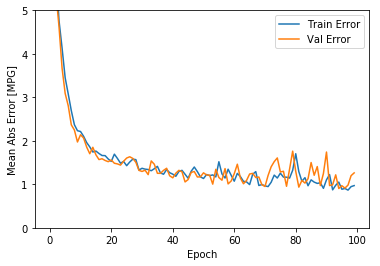

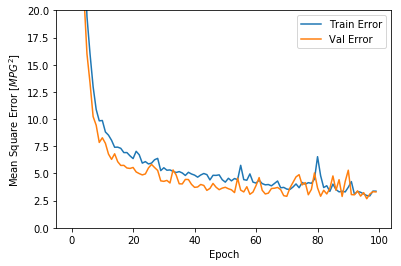

In [38]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')
    
EPOCHS = 100

history = model_rad.fit(
  train_data_rad, train_labels_rad,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[PrintDot()])

plot_history(history)

The above plot is a good example of how the error on the validation data can actually increase after a certain epoch-value is reached.


....................................................................................................

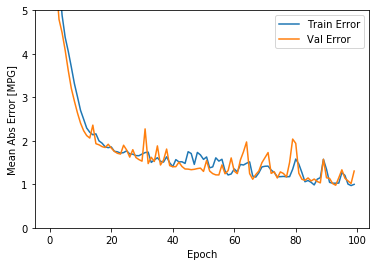

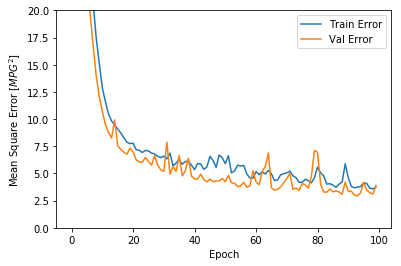

In [39]:
model = build_model_rad()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_data_rad, train_labels_rad, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
results = model.evaluate(test_data_rad, test_labels_rad)
print(results)


100/100 [==============================] - 0s 91us/sample - loss: 7.0701 - mean_absolute_error: 1.4771 - mean_squared_error: 7.0701 - accuracy: 0.9500
[7.070121939182282, 1.4770552, 7.0701222, 0.95]


Multilayer perceptron: final accuracy ~ 93%; initial MSE ~ 1019.7198 ; final MSE ~ 7.7464.

CNN: final accuracy ~ 96%; intitial MSE ~ 797.3132; final MSE ~ 4.2162.

CNN w/ MaxPooling layer: final accuracy ~ 97%; initial MSE ~ 800.8616; final MSE ~ 3.8766.

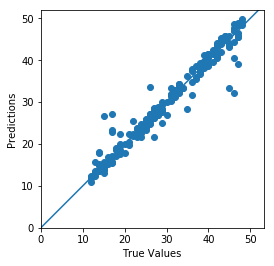

In [41]:
test_predictions_rad = model_rad.predict(test_data_rad).flatten()
plt.scatter(test_labels_rad, test_predictions_rad)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])